In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import sys
from tqdm.auto import tqdm


In [2]:
# options for calc return
calc_ret=True # cal or read from saved results
save_ret=True
R_max_calc_ret=10

idx_ver=1
R=10
alpha=0.05
delta=0.0
l_fixed=10.0
rf_source='KR_LS'

dir_B='../Data/B_max_ttm_10yr/'
dir_disc='./ret_curve_R_{}_alpha_{}_ridge_{}_RF_{}_daily_ver_{}/'.format(R, alpha, l_fixed, rf_source, idx_ver)
print(dir_disc)

dir_out='./summary_results/summary_ret_curve_R_{}_alpha_{}_ridge_{}_RF_{}_daily_ver_{}/'\
    .format(R, alpha, l_fixed, rf_source, idx_ver)
if not os.path.isdir(dir_out):
    os.makedirs(dir_out)
    
### load fit param
with open(dir_disc+"dict_ret_curve_par.pkl", "rb") as handle:
    dict_par_fit = pickle.load(handle)
assert rf_source== dict_par_fit['rf_source']   
assert dict_par_fit['freq']=='daily'
g_daily_type=dict_par_fit['g_daily_type']
    
### load daily risk-free rate
df_rf=pd.read_pickle('../data_supplement/df_riskfree_daily_all.pkl').KR_LS

# load lookup table
df_t_lookup_freq=pd.read_pickle(dir_B+'df_t_lookup_{}.pkl'.format('daily'))
df_t_lookup_freq=df_t_lookup_freq.iloc[:-1]
T=len(df_t_lookup_freq)
date_index=df_t_lookup_freq.index[:T]

date_index_monthly=pd.date_range(date_index[0],date_index[-1],freq='MS')
T_monthly=len(date_index_monthly)

# load price and return
B_mat=np.load(dir_B+'B_mat.npy')
Bc_shift_mat=np.load(dir_B+'Bc_shift_mat.npy')


# load param
with open(dir_B+"dict_par.pkl", "rb") as handle:
    dict_par = pickle.load(handle)
nmax,Nmax,prefix_C,dir_npz=[dict_par[key] for key in ['nmax','Nmax','prefix_C','npz_dir']]
dir_npz='../Data/npz_C/'

# load estimate of zcb monthly return for sanity check
df_g = pd.read_pickle('../data_supplement/df_kr_g.pkl')

### load mask
dir_mask='../mask/'
mat_mask_maturity=np.load(dir_mask+'mat_filter_maturity_90days.npy')
mat_nt=np.load(dir_mask+'mat_nt.npy')
mat_ytm=np.load(dir_mask+'mat_ytm.npy')

### print param fit
with open(dir_disc+"dict_ret_curve_par.pkl", "rb") as handle:
    dict_par_fit = pickle.load(handle)
display(dict_par_fit)
    

./ret_curve_R_10_alpha_0.05_ridge_10.0_RF_KR_LS_daily_ver_1/


{'T': 15118,
 'Nmax': 3650,
 'Nmax_C': 3651,
 'nmax': 380,
 't0': Timestamp('1961-06-14 00:00:00'),
 'tT-1': Timestamp('2021-12-31 00:00:00'),
 'num_kytreasno': 5586,
 'prefix_C': 'C_10yr_',
 'npz_dir': './npz_C_10yr_ver_12312021/',
 'freq': 'daily',
 'flg_mp': False,
 'num_t_each_trunk': 1000,
 'max_num_process': 3,
 'R': 10,
 'lst_R_fit': '',
 'use_maturity_mask': True,
 'l_fixed': 10.0,
 'alpha_fixed': 0.05,
 'delta_fixed': 0.0,
 'rf_source': 'KR_LS',
 'dir_kernel': '/share/data/discount_curve/discount_curve_construct_May.9,2022/kernel_matrix_depository/baseline_alpha_{}_delta_{}/',
 'g_daily_type': 'KR_LS',
 'filename_g_daily': 'df_kr_g.pkl',
 'dir_out_base': './KR_ret_models/',
 'dir_B': '',
 'idx_ver': 1}

# Read estimates

In [5]:
arr_date_s=np.full(T, np.nan)

if calc_ret:
    dict_ret={'mat_rx_g':np.full((T,Nmax),np.nan), # fit of zcb_ret_excess
              'mat_ret_g':np.full((T,Nmax),np.nan), # fit of zcb_ret
             'mat_rx':np.full((T,nmax),np.nan), # fit of rx of bonds
              'arr_rmse':np.full(T,np.nan)# quality of rx fit
             }
    for r in range(1,R_max_calc_ret+1):
        dict_ret[r]={'mat_rx_g':np.full((T,Nmax),np.nan),# fit of zcb_ret_excess
                     'mat_ret_g':np.full((T,Nmax),np.nan),# fit of zcb_ret
                     'mat_rx':np.full((T,nmax),np.nan),# fit of rx of bonds
                     'mat_F_rx':np.full((T,r),np.nan),# rx of factors with sign normalization
                     'mat_F_ret':np.full((T,r),np.nan), # return of factors with sign normalization
                     'mat_F_ret_1':np.full((T,r),np.nan), # temp
                     'mat_F_ret_2':np.full((T,r),np.nan), # temp
                     'arr_rmse':np.full((T,r),np.nan), # quality of rx fit
                     'arr_sign':np.full(T,np.nan) # sign array to multiply with VD^{1/2}
                    }
    
    pbar=tqdm(total=T)
    for t_freq in range(0,T):
        t=df_t_lookup_freq.iloc[t_freq].t
        with open(dir_disc+'dict_ret_curve_tfreq_{}_t_{}.pkl'.format(t_freq,t),\
                  "rb") as handle:
            dict_t = pickle.load(handle) 
            
        ret=dict_t['ret']
        rf=dict_t['rf'] # multiple days
        nt=dict_t['dict_full']['rx_full'].shape[0]
        arr_date_s[t_freq]=dict_t['date_s']
        
        dict_ret['mat_rx_g'][t_freq,:]=dict_t['dict_full']['rx_g_full'] 
        dict_ret['mat_ret_g'][t_freq,:]=dict_t['dict_full']['rx_g_full']+rf
        dict_ret['mat_rx'][t_freq,:nt]=dict_t['dict_full']['rx_full'] 
        dict_ret['arr_rmse'][t_freq]=dict_t['dict_full']['rmse'] 
        
        for r in range(1,R_max_calc_ret+1):
            dict_ret[r]['mat_rx_g'][t_freq,:]=dict_t['dict_fm'][r]['rx_g_fm']
            dict_ret[r]['mat_ret_g'][t_freq,:]=dict_t['dict_fm'][r]['rx_g_fm']+rf
            dict_ret[r]['mat_rx'][t_freq,:nt]=dict_t['dict_fm'][r]['rx_fm']
            dict_ret[r]['mat_F_rx'][t_freq,:]=dict_t['dict_fm'][r]['F_rx_fm']
            dict_ret[r]['arr_rmse'][t_freq]=dict_t['dict_fm'][r]['rmse_fm']
            
            # return of factor
            w_fm_1=dict_t['dict_fm'][r]['w_fm']
            w_fm_2=-1*w_fm_1
            
            F_ret_fm_1=w_fm_1@ret+(1-w_fm_1@np.ones(nt))*rf
            F_ret_fm_2=w_fm_2@ret+(1-w_fm_2@np.ones(nt))*rf
            
            dict_ret[r]['mat_F_ret_1'][t_freq,:]=F_ret_fm_1
            dict_ret[r]['mat_F_ret_2'][t_freq,:]=F_ret_fm_2

        pbar.update(1)
        
    # normalize sign of factor
    for r in range(1,R_max_calc_ret+1):
        arr_sign=np.sign(dict_ret[r]['mat_F_rx'].mean(axis=0))
        dict_ret[r]['mat_F_rx']=dict_ret[r]['mat_F_rx']*arr_sign
        for j in range(r):
            if arr_sign[j]==1:
                dict_ret[r]['mat_F_ret'][:,j]=dict_ret[r]['mat_F_ret_1'][:,j]
            else:
                dict_ret[r]['mat_F_ret'][:,j]=dict_ret[r]['mat_F_ret_2'][:,j]
        del dict_ret[r]['mat_F_ret_1']
        del dict_ret[r]['mat_F_ret_2'] 
        dict_ret[r]['arr_sign']=arr_sign
            
    if save_ret:
        with open(dir_out+'dict_ret.pkl','wb') as handle:
            pickle.dump(dict_ret,handle,protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(dir_out+'dict_ret.pkl',"rb") as handle:
        dict_ret = pickle.load(handle) 

  0%|          | 0/14865 [00:00<?, ?it/s]

# utils

In [ ]:
def print_matrix(A,title=None,num_digit=4,lst_header=None,print_multiplier=1):
    '''
    print(print_matrix(A))
    '''
    str_out=''
    (num_row,num_col)=A.shape
    if title is not None:
        assert len(title)==num_row
    if lst_header is not None:
        for i,header in enumerate(lst_header):
            if i==len(lst_header)-1:
                str_out+=header+'\\\\'
            else:
                str_out+=header+'&'
        str_out+='\n'
        
    for i in range(0,num_row):
        str_temp=''
        if title is not None:
            str_temp+=title[i]+'&'
        for j in range(0,num_col):
            str_temp+=np.array2string(A[i,j]*print_multiplier,precision=num_digit)
            if j==num_col-1:
                str_temp+='\\\\'
            else:
                str_temp+='&'
        #str_temp=str_temp.replace('<','$<$').replace('>','$>$')
        str_out+=str_temp+'\n'
    return str_out

# fitting of excess returns of underlying securities

In [ ]:
t_freq=14000 

t=df_t_lookup_freq.iloc[t_freq].t
date=df_t_lookup_freq.index[t_freq]
date_s=(df_t_lookup_freq.index[t_freq+1]-df_t_lookup_freq.index[t_freq]).days


B=B_mat[:,t]
nt=int(mat_nt[t])

# filter step
if dict_par_fit['use_maturity_mask']:
    mask_keep=mat_mask_maturity[t,:nt]
    mask_keep=np.logical_and(mask_keep, mat_ytm[t,:nt] < 0.25) 
else:
    mask_keep=np.full(nt, True)

csr_mat_name=dir_npz+prefix_C+'C_'+str(t)+'.npz'
csr_mat=sps.load_npz(csr_mat_name)

# remove empty rows from B and C
# apply filter
B=B[:nt][mask_keep]
Bc_shift=Bc_shift_mat[:nt,t][mask_keep]
C=csr_mat.toarray()[:nt,1:][mask_keep]
nt=len(B)

# get ttm in day for further analysis
lst_ttm_inday=np.apply_along_axis(lambda row: len(row)-(row!=0)[::-1].argmax(),1,C)

with open(dir_disc+'dict_ret_curve_tfreq_{}_t_{}.pkl'.format(t_freq,t),\
                  "rb") as handle:
    dict_t = pickle.load(handle) 
    
fig=plt.figure(figsize=(15,6))
ax_1,ax_2=fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

#rx_g=dict_t['rx_g']
rx_g_full=dict_t['dict_full']['rx_g_full']

rx=dict_t['rx']
rx_full=dict_t['dict_full']['rx_full']

ax_1.plot(np.sort(lst_ttm_inday),rx[np.argsort(lst_ttm_inday)],'--o',label=r'True $R_{t+1}^e$')
ax_1.plot(np.sort(lst_ttm_inday),rx_full[np.argsort(lst_ttm_inday)],'--o',label=r'Fitted $R_{t+1}^e$')

#ax_2.plot(rx_g,label=r'True $R_{g,t+1}^e$')
ax_2.plot(rx_g_full,label=r'Fitted $R_{g,t+1}^e$')

for ax in [ax_1,ax_2]:
    ax.legend();
    
fig.suptitle(r'Fit on {}; $\alpha$={}; $\lambda$={}'.format(date.strftime('%Y-%m-%d'),alpha,l_fixed));

# factors

In [20]:
# compile results
date_index=df_t_lookup_freq.index[:T]
dict_factor=dict()
for r in range(1,R_max_calc_ret+1):
    # factors based on rx
    df_factor_rx_daily=pd.DataFrame(index=date_index,
                 data=dict_ret[r]['mat_F_rx'],
                 columns=np.arange(1,r+1))
    # daily return (not rx) of factors
    df_factor_ret_daily=pd.DataFrame(index=date_index,
                 data=dict_ret[r]['mat_F_ret'],
                 columns=np.arange(1,r+1))
    # monthly return of factors
    df_factor_ret_monthly=(df_factor_ret_daily+1).\
        groupby(df_factor_ret_daily.index.strftime('%Y-%m')).prod()-1
    
    # remove the first month and last month
    df_factor_ret_monthly=df_factor_ret_monthly[1:-1]
    df_factor_ret_monthly.index=date_index_monthly[:-12][:-1]
    
    # get monthly rx using FF RF
    df_factor_rx_monthly=df_factor_ret_monthly-df_ff_rf.loc[df_factor_ret_monthly.index].values
    
    
    dict_factor[r]={'df_factor_rx_daily':df_factor_rx_daily,
                   'df_factor_ret_daily':df_factor_ret_daily,
                   'df_factor_ret_monthly':df_factor_ret_monthly,
                    'df_factor_rx_monthly':df_factor_rx_monthly,
                    'arr_sign':dict_ret[r]['arr_sign']
                   }

# daily return and rx

In [8]:
date_index=df_t_lookup_freq.index[:T]

In [21]:
df_zcb_ret_daily=pd.DataFrame(index=date_index,
                              data=dict_ret['mat_ret_g'],
                              columns=np.arange(1,Nmax+1))
df_zcb_rx_daily=pd.DataFrame(index=date_index,
                              data=dict_ret['mat_rx_g'],
                              columns=np.arange(1,Nmax+1))
dict_zcb={'df_zcb_ret_daily':df_zcb_ret_daily,
           'df_zcb_rx_daily':df_zcb_rx_daily
           }

In [10]:
# get daily return and rx implied by df_g_daily
# and compare with fitted values

arr_ret_imp=np.full((T,Nmax),np.nan)
arr_rx_imp=np.full((T,Nmax),np.nan)
for t in range(T):
    df_g_t=df_g.iloc[t]
    df_g_next=df_g.iloc[t+1]
    date_s=(df_g.index[t+1]-df_g.index[t]).days

    g_t=df_g_t.values
    g_next_shift=np.roll(df_g_next,date_s)
    g_next_shift[date_s-1]=1
    g_next_shift[:date_s-1]=np.nan

    ret=(g_next_shift-g_t)/g_t
    rf=(1+df_rf.loc[df_g.index[t]])**date_s-1
    rx=ret-rf
    
    arr_ret_imp[t]=ret[:Nmax]
    arr_rx_imp[t]=rx[:Nmax]

df_zcb_ret_imp=pd.DataFrame(index=date_index,
                            data=arr_ret_imp,
                           columns=np.arange(1,Nmax+1))
df_zcb_rx_imp=pd.DataFrame(index=date_index,
                            data=arr_rx_imp,
                           columns=np.arange(1,Nmax+1))

# cumulative returns of factors

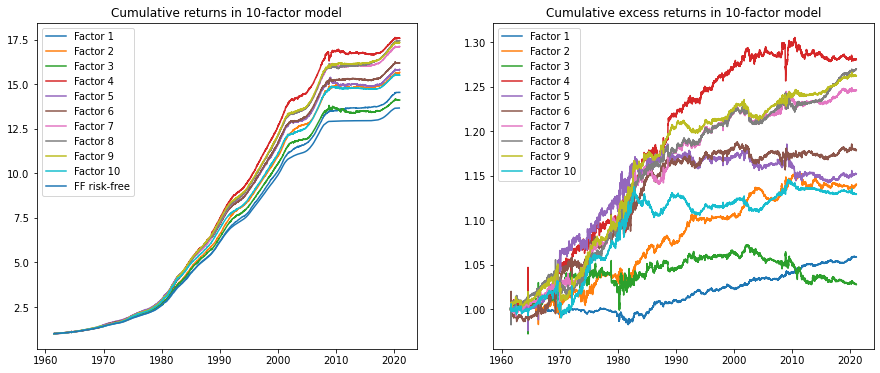

In [ ]:
r=10
df_ret_temp=dict_factor[r]['df_factor_ret_daily']
df_rx_temp=dict_factor[r]['df_factor_rx_daily']

fig=plt.figure(figsize=(15,6))
ax_1,ax_2=fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

for j in range(1,r+1):
    ax_1.plot(np.cumprod(df_ret_temp[j]+1,axis=0),label='Factor {}'.format(j))
    ax_2.plot(np.cumprod(df_rx_temp[j]+1,axis=0),label='Factor {}'.format(j))

ax_1.plot(np.cumprod(df_ff_rf.RF+1,axis=0),label='FF risk-free')
for ax in [ax_1,ax_2]:
    ax.legend();
ax_1.set_title('Cumulative returns in {}-factor model'.format(r));
ax_2.set_title('Cumulative excess returns in {}-factor model'.format(r));

# save to output

In [47]:
# factor return (daily, monthly), rx (daily)
with open(dir_out+'dict_factor.pkl','wb') as handle:
        pickle.dump(dict_factor,handle,protocol=pickle.HIGHEST_PROTOCOL)
print(dict_factor.keys())
print(dict_factor[1].keys())


with open(dir_out+'dict_zcb.pkl','wb') as handle:
        pickle.dump(dict_zcb,handle,protocol=pickle.HIGHEST_PROTOCOL)
print(dict_zcb.keys())


dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys(['df_factor_rx_daily', 'df_factor_ret_daily', 'df_factor_ret_monthly', 'df_factor_rx_monthly', 'arr_sign'])
dict_keys(['df_zcb_ret_daily', 'df_zcb_rx_daily'])


In [48]:
# rx g and ret g

dict_rx_g={'rx_g':{}, 'ret_g':{},
           'rx_g_oneday_v1':{}, 'ret_g_oneday_v1':{},
           'rx_g_oneday_v2':{}, 'ret_g_oneday_v2':{}}

### multiple days
for r in range(1,1+R_max_calc_ret):
    dict_rx_g['rx_g'][r]=dict_ret[r]['mat_rx_g'].mean(axis=0)
    dict_rx_g['ret_g'][r]=dict_ret[r]['mat_ret_g'].mean(axis=0)
    
dict_rx_g['rx_g']['Full']=dict_ret['mat_rx_g'].mean(axis=0)
dict_rx_g['ret_g']['Full']=dict_ret['mat_ret_g'].mean(axis=0)

### one day ver 1
rf_oneday=df_rf.iloc[:-1].values
for r in range(1,1+R_max_calc_ret):
    mat_ret_g_oneday=(1+dict_ret[r]['mat_ret_g'])**(1/arr_date_s[:,np.newaxis])-1
    mat_rx_g_oneday=mat_ret_g_oneday-rf_oneday[:,np.newaxis]
    dict_rx_g['rx_g_oneday_v1'][r]=mat_rx_g_oneday.mean(axis=0)
    dict_rx_g['ret_g_oneday_v1'][r]=mat_ret_g_oneday.mean(axis=0)
    
mat_ret_g_oneday=(1+dict_ret['mat_ret_g'])**(1/arr_date_s[:,np.newaxis])-1
mat_rx_g_oneday=mat_ret_g_oneday-rf_oneday[:,np.newaxis]
dict_rx_g['rx_g_oneday_v1']['Full']=mat_rx_g_oneday.mean(axis=0)
dict_rx_g['ret_g_oneday_v1']['Full']=mat_ret_g_oneday.mean(axis=0)

### one day ver 2
for r in range(1,1+R_max_calc_ret):
    dict_rx_g['rx_g_oneday_v2'][r]=((1+dict_ret[r]['mat_rx_g'])**(1/arr_date_s[:,np.newaxis])-1).mean(axis=0)
    dict_rx_g['ret_g_oneday_v2'][r]=((1+dict_ret[r]['mat_ret_g'])**(1/arr_date_s[:,np.newaxis])-1).mean(axis=0)
    
dict_rx_g['rx_g_oneday_v2']['Full']=((1+dict_ret['mat_rx_g'])**(1/arr_date_s[:,np.newaxis])-1).mean(axis=0)
dict_rx_g['ret_g_oneday_v2']['Full']=((1+dict_ret['mat_ret_g'])**(1/arr_date_s[:,np.newaxis])-1).mean(axis=0)


with open(dir_out+'dict_rx_g.pkl','wb') as handle:
    pickle.dump(dict_rx_g,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
print(np.equal(dict_rx_g['rx_g_oneday_v1']['Full'], dict_rx_g['rx_g_oneday_v2']['Full']).all())
print(np.isclose(dict_rx_g['rx_g_oneday_v1']['Full'], dict_rx_g['rx_g_oneday_v2']['Full']).all())


print(np.equal(dict_rx_g['ret_g_oneday_v1']['Full'], dict_rx_g['ret_g_oneday_v2']['Full']).all())
print(np.isclose(dict_rx_g['ret_g_oneday_v1']['Full'], dict_rx_g['ret_g_oneday_v2']['Full']).all())

False
True
True
True
